# Creating a Translated Dataset

This notebook demonstrates how to create a dataset with a percentage of queries translated from English to Polish.

## Setup

First, let's set up our environment and import necessary libraries.

In [ ]:
import sys
sys.path.append('..')  # Add parent directory to path

import json
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.dataset import parse_json_entry
from src.translation_dataset import (
    create_translated_dataset,
    analyze_translated_dataset
)

# Visual settings
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')

## Creating a Small Test Dataset

First, let's create a small test dataset with a few translated queries to verify that everything works as expected.

In [2]:
# Path for the test dataset
test_output_path = Path('../data/test_translated_dataset.json')

# Create a small dataset with 10 samples, 50% translated
test_dataset_path = create_translated_dataset(
    output_path=test_output_path,
    sample_size=10,
    translation_percentage=0.5,
    random_seed=42
)

print(f"Test dataset created at: {test_dataset_path}")

2025-03-25 18:15:03,889 - INFO - Ensured data directory exists


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
2025-03-25 18:15:04,127 - WARNING - Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
2025-03-25 18:15:04,128 - INFO - Loading dataset Salesforce/xlam-function-calling-60k


Successfully logged in to Hugging Face


2025-03-25 18:15:07,841 - INFO - Dataset loaded with 60000 samples
2025-03-25 18:15:07,851 - INFO - Sampled 10 entries from the dataset
2025-03-25 18:15:07,853 - INFO - Starting translation of 50.0% of the queries
2025-03-25 18:15:07,853 - INFO - Translating queries for 5 out of 10 samples (50.0%)
2025-03-25 18:15:13,219 - INFO - Translated 5/5 queries
2025-03-25 18:15:13,321 - INFO - Translation completed. Translated 5 queries.
2025-03-25 18:15:13,323 - INFO - Saving translated dataset to ../data/test_translated_dataset.json
2025-03-25 18:15:13,325 - INFO - Successfully saved 10 samples with 50.0% translated queries


Test dataset created at: ../data/test_translated_dataset.json


## Analyzing the Test Dataset

Let's analyze the test dataset to verify the translations.

In [3]:
# Load and explore the test dataset
with open(test_output_path, 'r', encoding='utf-8') as f:
    test_data = json.load(f)

# Display the queries from the first few samples
print("Queries in the test dataset:")
for i, sample in enumerate(test_data):
    print(f"Sample {i+1}: {sample['query']}\n")

Queries in the test dataset:
Sample 1: Jaka jest szerokość i długość adresów IP '74 .125.24.100 'i '74 .125.24.101'?

Sample 2: Tworzę łamigłówkę dla różnych grup wiekowych.Potrzebuję 7 łatwych słów dla dzieci, 14 średnich słów dla nastolatków i 20 twardych słów dla dorosłych.

Sample 3: Pobrać informacje dla pojazdu z VIN 5xYZU3LA3DG123456.

Sample 4: Odzyskaj przypadkowy fałszywy rekord banku z ID 987.

Sample 5: Jaki jest wynik Flames dla nazwisk „John” i „Mary”?

Sample 6: Place a small order at the Whole Foods located at 789 Red Boulevard. I need to order cheese, yogurt, and butter.

Sample 7: Compute the Euclidean distance between points (10, 10) and (20, 20).

Sample 8: Retrieve news on COVID-19 from the Health section in English for the US.

Sample 9: What are some fake Google autocomplete suggestions for 'how to', 'do a backflip', and 'safely'? Also, provide the cast and crew of the movie 'The Dark Knight'.

Sample 10: Find the 7th smallest number in the list [12, 34, 56, 78, 

In [4]:
# Analyze the language distribution
test_summary = analyze_translated_dataset(test_output_path)
print("Language distribution in the test dataset:")
test_summary

2025-03-25 18:16:02,388 - INFO - Analyzing translated dataset at ../data/test_translated_dataset.json
2025-03-25 18:16:02,399 - INFO - Analysis complete - found 10 samples


Language distribution in the test dataset:


,Language,Count,Percentage
0,English,6,60.0
1,Polish,4,40.0


## Creating the Full Translated Dataset

Now, let's create the full dataset with 40% of queries translated to Polish. Depending on the size of the dataset, this may take some time to complete.

In [6]:
# Path for the full dataset
full_output_path = Path('../data/xlam_function_calling_pl.json')

# Option 1: Creating a full dataset with all samples (this will take a long time)
# full_dataset_path = create_translated_dataset(
#     output_path=full_output_path,
#     translation_percentage=0.4,
#     random_seed=42
# )

# Option 2: Creating a more manageable dataset (e.g., 2000 samples)
sample_size = 2000  # Adjust based on your needs and resources
full_dataset_path = create_translated_dataset(
    output_path=full_output_path,
    sample_size=sample_size,
    translation_percentage=0.4,
    random_seed=42
)

print(f"Full dataset created at: {full_dataset_path}")

2025-03-25 18:17:14,044 - INFO - Ensured data directory exists


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
2025-03-25 18:17:14,253 - WARNING - Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
2025-03-25 18:17:14,255 - INFO - Loading dataset Salesforce/xlam-function-calling-60k


Successfully logged in to Hugging Face


2025-03-25 18:17:16,633 - INFO - Dataset loaded with 60000 samples
2025-03-25 18:17:16,642 - INFO - Sampled 2000 entries from the dataset
2025-03-25 18:17:16,644 - INFO - Starting translation of 40.0% of the queries
2025-03-25 18:17:16,645 - INFO - Translating queries for 800 out of 2000 samples (40.0%)
2025-03-25 18:17:22,435 - INFO - Translated 10/800 queries
2025-03-25 18:17:29,069 - INFO - Translated 20/800 queries
2025-03-25 18:17:35,855 - INFO - Translated 30/800 queries
2025-03-25 18:17:43,648 - INFO - Translated 40/800 queries
2025-03-25 18:17:52,553 - INFO - Translated 50/800 queries
2025-03-25 18:18:01,360 - INFO - Translated 60/800 queries
2025-03-25 18:18:11,761 - INFO - Translated 70/800 queries
2025-03-25 18:18:23,990 - INFO - Translated 80/800 queries
2025-03-25 18:18:32,043 - INFO - Translated 90/800 queries
2025-03-25 18:18:41,142 - INFO - Translated 100/800 queries
2025-03-25 18:18:52,609 - INFO - Translated 110/800 queries
2025-03-25 18:19:03,135 - INFO - Translated 

Full dataset created at: ../data/xlam_function_calling_pl.json


## Analyzing the Full Dataset

Now, let's analyze the full dataset to verify that approximately 40% of the queries have been translated.

In [7]:
# Analyze the language distribution
full_summary = analyze_translated_dataset(full_output_path)
print("Language distribution in the full dataset:")
full_summary

2025-03-25 18:36:42,182 - INFO - Analyzing translated dataset at ../data/xlam_function_calling_pl.json
2025-03-25 18:36:42,198 - INFO - Analysis complete - found 2000 samples


Language distribution in the full dataset:


,Language,Count,Percentage
0,English,1241,62.05
1,Polish,759,37.95


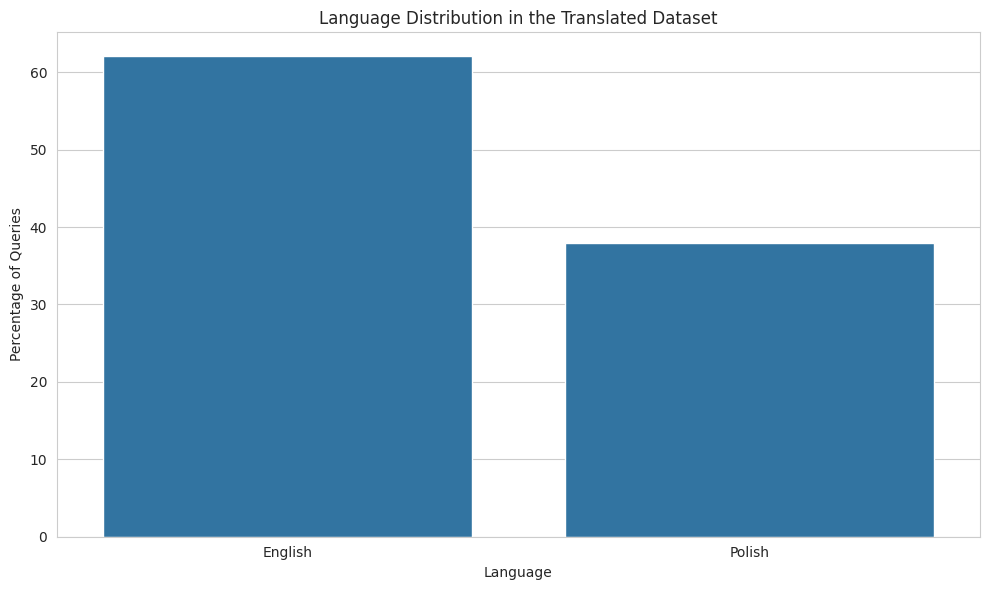

In [8]:
# Visualize the language distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Language', y='Percentage', data=full_summary)
plt.title('Language Distribution in the Translated Dataset')
plt.xlabel('Language')
plt.ylabel('Percentage of Queries')
plt.tight_layout()
plt.savefig('../data/language_distribution.png')
plt.show()

## Examining Examples of Translated Queries

Let's look at some examples of translated queries to verify the quality.

In [9]:
# Load the full dataset
with open(full_output_path, 'r', encoding='utf-8') as f:
    full_data = json.load(f)

# Function to detect if a query is in Polish (simplified)
def is_polish(text):
    return any(c in text for c in 'ąćęłńóśźżĄĆĘŁŃÓŚŹŻ')

# Get examples of English and Polish queries
english_examples = []
polish_examples = []

for sample in full_data:
    query = sample['query']
    if len(english_examples) < 5 and not is_polish(query):
        english_examples.append(query)
    elif len(polish_examples) < 5 and is_polish(query):
        polish_examples.append(query)
        
    if len(english_examples) >= 5 and len(polish_examples) >= 5:
        break

# Display examples
print("Examples of English Queries:")
for i, query in enumerate(english_examples):
    print(f"{i+1}. {query}\n")

print("\nExamples of Polish Queries:")
for i, query in enumerate(polish_examples):
    print(f"{i+1}. {query}\n")

Examples of English Queries:
1. Jaki jest wynik Flames dla nazwisk „John” i „Mary”?

2. Pobierz dane Ticker dla Ethereum na rynkach USD i euro.

3. Odzyskaj zwolnienia prasowe dla Tesli na stronie 1.

4. Pobieraj produkty z pierwszych 3 stron sklepu Nike Shopify.

5. Oblicz odchylenie standardowe liczb 5, 10, 15, 20, 25.


Examples of Polish Queries:
1. Jaka jest szerokość i długość adresów IP '74 .125.24.100 'i '74 .125.24.101'?

2. Tworzę łamigłówkę dla różnych grup wiekowych.Potrzebuję 7 łatwych słów dla dzieci, 14 średnich słów dla nastolatków i 20 twardych słów dla dorosłych.

3. Pobrać informacje dla pojazdu z VIN 5xYZU3LA3DG123456.

4. Odzyskaj przypadkowy fałszywy rekord banku z ID 987.

5. Złóż małe zamówienie w Whole Foods położonym przy 789 Red Boulevard.Muszę zamówić ser, jogurt i masło.



## Verify Dataset Structure

Let's verify that the dataset structure is maintained, with only the queries translated.

In [10]:
# Select a sample with a Polish query
polish_sample = None
for sample in full_data:
    if is_polish(sample['query']):
        polish_sample = sample
        break

if polish_sample:
    # Parse the sample to examine its structure
    parsed_sample = parse_json_entry(polish_sample)
    
    print("Structure of a sample with a Polish query:")
    print(f"Query: {parsed_sample['query']}\n")
    
    print("Tools:")
    for tool in parsed_sample['tools'][:2]:  # Show first two tools
        print(f"- Name: {tool['name']}")
        print(f"  Description: {tool['description']}")
        print(f"  Parameters: {list(tool['parameters'].keys())}\n")
    
    print("Answers:")
    for answer in parsed_sample['answers'][:2]:  # Show first two answers
        print(f"- Tool: {answer['name']}")
        print(f"  Arguments: {answer['arguments']}\n")
else:
    print("No sample with a Polish query found.")

Structure of a sample with a Polish query:
Query: Jaka jest szerokość i długość adresów IP '74 .125.24.100 'i '74 .125.24.101'?

Tools:
- Name: get_ip_location
  Description: Retrieves the latitude and longitude coordinates of a given IP address using the ip-api.com API.
  Parameters: ['ip']

Answers:
- Tool: get_ip_location
  Arguments: {'ip': '74.125.24.100'}

- Tool: get_ip_location
  Arguments: {'ip': '74.125.24.101'}



## Save Dataset Statistics

Finally, let's save some statistics about the dataset.

In [11]:
# Prepare dataset statistics
stats = {
    "total_samples": len(full_data),
    "english_samples": int(full_summary[full_summary['Language'] == 'English']['Count'].values[0] 
                           if 'English' in full_summary['Language'].values else 0),
    "polish_samples": int(full_summary[full_summary['Language'] == 'Polish']['Count'].values[0] 
                          if 'Polish' in full_summary['Language'].values else 0),
    "polish_percentage": float(full_summary[full_summary['Language'] == 'Polish']['Percentage'].values[0] 
                              if 'Polish' in full_summary['Language'].values else 0),
}

# Display statistics
for key, value in stats.items():
    print(f"{key}: {value}")

# Save statistics to file
stats_path = Path('../data/dataset_stats.json')
with open(stats_path, 'w', encoding='utf-8') as f:
    json.dump(stats, f, indent=2)

print(f"\nStatistics saved to {stats_path}")

total_samples: 2000
english_samples: 1241
polish_samples: 759
polish_percentage: 37.95

Statistics saved to ../data/dataset_stats.json


## Conclusion

In this notebook, we have:

1. Created a small test dataset to verify the translation functionality
2. Created a larger dataset with approximately 40% of queries translated to Polish
3. Analyzed and visualized the language distribution in the dataset
4. Verified that the dataset structure is maintained, with only the queries translated
5. Saved statistics about the dataset